In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

# Seting up a 2D mesh and model

In [3]:
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)

In [4]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [5]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
chi[poly_inds] = 0.005

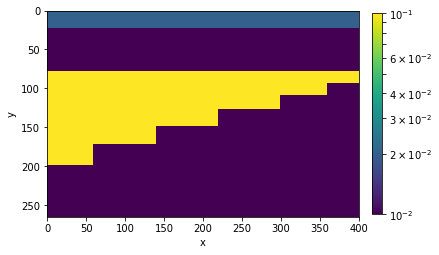

In [6]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

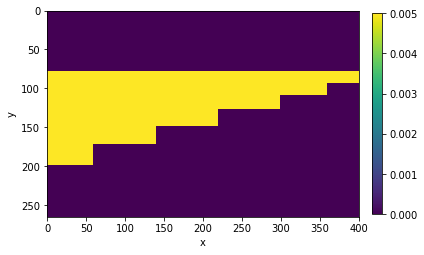

In [7]:
cb = plt.colorbar(
    mesh.plotImage(chi, grid=False)[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [8]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [9]:
mapping = Maps.ExpMap(mesh)

In [10]:
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo    
)
prob = GlobalEM1DProblemFD(
    [], sigmaMap=mapping, chi=chi, hz=hz, parallel=False, n_cpu=2, verbose=True,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Serial version is used


In [11]:
m = np.log(sigma_em1d)

In [15]:
%%time
dobs = survey.dpred(m)

Compute fields
>> Compute response
Wall time: 161 ms


In [16]:
DOBS = dobs.reshape(( prob.n_sounding, 2, survey.n_frequency))

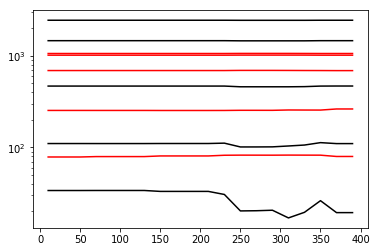

In [17]:
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'r')    

In [18]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

In [19]:
mesh_reg = Mesh.TensorMesh([mesh.hy, mesh.hx])

In [20]:
%%time
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = Regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s=1.,
    alpha_x = 1.,
    alpha_y = 1.,    
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True, betaSearch=False
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields
>> Compute response
>> Compute J


C:\Users\seogi\Projects\simpeg\SimPEG\Directives.py:886: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.69e+01  5.72e+03  0.00e+00  5.72e+03    8.52e+02      0              
Compute fields
>> Compute response
>> Compute J
   1  8.43e+00  9.83e+02  4.42e+01  1.36e+03    1.27e+02      0              
Compute fields
>> Compute response
>> Compute J
   2  4.22e+00  6.61e+02  5.92e+01  9.11e+02    5.42e+01      0              
Compute fields
>> Compute response
>> Compute J
   3  2.11e+00  3.65e+02  9.51e+01  5.66e+02    4.93e+01      0   Skip BFGS  
Compute fields
>> Compute response
>> Compute J
   4  1.05e+00  1.57e+02  1.44e+02  3.08e+02    4.48e+01      0   Skip BFGS  
Compute fields
>> Compute response
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 2.071852226430884 eps_q: 2.0

In [21]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [22]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5,1,'Laterally-contrained model: L0 L2')

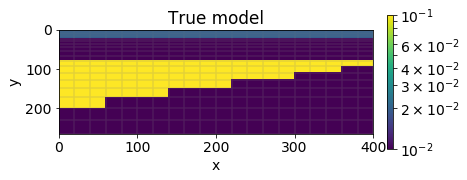

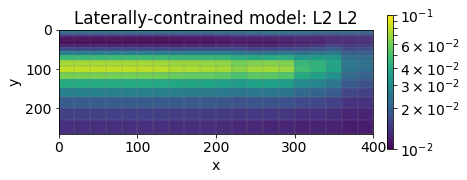

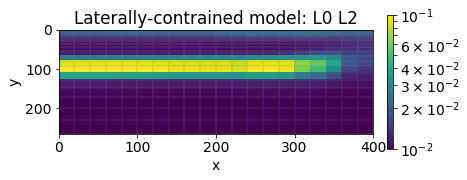

In [23]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)
plt.title("Laterally-contrained model: L0 L2")